In [6]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import time
from copy import deepcopy
import matplotlib.pyplot as plt

from f1_elo.fetch_and_save import (
    load_elo_ratings,
    read_game_listing,
    save_prepare_season_initial_ratings,
    save_ratings,
)

import warnings
warnings.filterwarnings("ignore")

In [7]:
def get_actual_game_listing(listing_path, team_season_path):
    listing = read_game_listing(path=listing_path)

    team_season = pd.read_csv(team_season_path, dtype={'season': 'string'})
    

    home_team_season = team_season.rename(columns={'team': 'home_team'})
    listing = listing.merge(home_team_season, how='inner', on=['home_team', 'season', 'tournament'])

    away_team_season = team_season.rename(columns={'team': 'away_team'})
    listing = listing.merge(away_team_season, how='inner', on=['away_team', 'season', 'tournament'])

    listing = _recalc_race_season_stats(listing=listing)

    return listing

In [8]:
def _recalc_race_season_stats(listing):
    listing = listing.drop(columns=['num_drivers', 'num_races'])

    home_driver_info = listing[['home_team', 'season', 'round', 'tournament']].rename(columns={'home_team': 'team'})
    away_driver_info = listing[['away_team', 'season', 'round', 'tournament']].rename(columns={'away_team': 'team'})

    driver_info = pd.concat([home_driver_info, away_driver_info], ignore_index=True).drop_duplicates()

    round_stats = driver_info.groupby(['tournament', 'season', 'round']).agg(num_drivers=('team', 'nunique')).reset_index()
    listing = listing.merge(round_stats, how='left', on=['tournament', 'season', 'round'])

    season_stats = driver_info.groupby(['tournament', 'season']).agg(num_races=('round', 'nunique')).reset_index()
    listing = listing.merge(season_stats, how='left', on=['tournament', 'season'])

    return listing

In [9]:
listing = get_actual_game_listing(listing_path='data/listing.csv', team_season_path='files/team_season.csv')

In [13]:
def get_prepare_season_listing(listing_path, team_season_path):
    """
    Retrieves game listings for the earliest season from a specified file.

    Arguments:
        listing_path (str): Path to the CSV file containing game listings.

    Returns:
        pandas.DataFrame: A DataFrame filtered to include only games from the earliest season.
    """
    listing = get_actual_game_listing(listing_path=listing_path, team_season_path=team_season_path)
    first_season = listing['season'].min()
    listing = listing.loc[listing['season'] == first_season]

    return listing

In [14]:
# listing = get_prepare_season_listing(listing_path='data/listing.csv', team_season_path='files/team_season.csv')

In [15]:
listing

,home_team,away_team,score,season,round,game_date,home_field,country,tournament,result,num_drivers,num_races
0,Nino Farina,Luigi Fagioli,2 : 1,1950,1,1950-05-13,no,world,F1,win1,7,6
1,Louis Rosier,Bob Gerard,6 : 5,1950,1,1950-05-13,no,world,F1,win1,7,6
2,Louis Rosier,Philippe Étancelin,8 : 5,1950,1,1950-05-13,no,world,F1,win1,7,6
3,Louis Rosier,Johnny Claes,11 : 5,1950,1,1950-05-13,no,world,F1,win1,7,6
4,Bob Gerard,Philippe Étancelin,8 : 6,1950,1,1950-05-13,no,world,F1,win1,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...
103796,Lewis Hamilton,George Russell,5 : 4,2024,24,2024-12-08,no,world,F1,win1,16,24
103797,Lewis Hamilton,Max Verstappen,6 : 4,2024,24,2024-12-08,no,world,F1,win1,16,24
103798,Lewis Hamilton,Pierre Gasly,7 : 4,2024,24,2024-12-08,no,world,F1,win1,16,24
103799,Charles Leclerc,Guanyu Zhou,13 : 3,2024,24,2024-12-08,no,world,F1,win1,16,24


In [48]:
class EloCalculation:
    """
    Class represents elo rating calculation logic.
    """
    def __init__(
        self,
        elo_rating_path,
        team_season_path,
        elo_game_value,
        num_rounds_degree,
        num_drivers_degree,
        new_agent_alpha=2,
        calibrated_rating=2000,
        default_rating=1800,        
        saturation_rounds=10,
    ):
        """
        Initializes an instance with paths to data files and Elo configuration parameters.

        Arguments:
            elo_rating_path (str): Path to the CSV file containing initial Elo ratings for teams.
            elo_game_value (float): The Elo adjustment factor used in rating updates.
            calibrated_rating (int/float): Average rating for top-n teams which should remain the same from season to season.

        Initializes:
            result_ratios (dict): Dictionary mapping match outcomes ('win1', 'draw', 'win2') to corresponding values.
            elo_ratings_dict (dict): Loaded Elo ratings for teams.
        """
        self.elo_rating_path = elo_rating_path
        self.team_season_path = team_season_path
        self.elo_game_value = elo_game_value
        self.num_rounds_degree = num_rounds_degree
        self.num_drivers_degree = num_drivers_degree
        self.calibrated_rating = calibrated_rating
        self.default_rating = default_rating
        self.saturation_rounds = saturation_rounds
        self.new_agent_alpha = new_agent_alpha
        
        self.result_ratios = {'win1': 1, 'draw': 0.5, 'win2': 0}
        self.num_games = 0
        self.total_log_loss = 0
        self.log_loss = 0

        self.team_season_combos = self._load_team_season_combinations()
        self.teams_years_active = self.team_season_combos.groupby(['team']).agg(
            first_season=('season', 'min'),
            last_season=('season', 'max'),
        ).reset_index()
        self.elo_ratings_dict = load_elo_ratings(path=self.elo_rating_path)
        self.num_games_per_team = {}

        self.temp_ratings = []
        self.output = []

    def reset_log_loss(self):
        self.num_games = 0
        self.total_log_loss = 0
        self.log_loss = 0

    def _load_team_season_combinations(self):
        """
        Load the team, league and season combinations.
        """
        team_season_combos = pd.read_csv(self.team_season_path )
        team_season_combos['season'] = team_season_combos['season'] .astype(str)

        return team_season_combos

    def run_round(self, listing):
        round_elo_rating_dict = deepcopy(self.elo_ratings_dict)
        keep_cols = ['game_date', 'tournament', 'season', 'home_team', 'away_team', 'result', 'score', 'num_drivers', 'num_races']
        listing_np = listing[keep_cols].to_numpy()

        for row in listing_np:
            game = dict(zip(keep_cols, row))
            home_team = game.get('home_team')
            away_team = game.get('away_team')

            if (home_team not in self.elo_ratings_dict) or (away_team not in self.elo_ratings_dict):
                continue

            round_elo_rating_dict = self.update_elo(game=game, round_elo_rating_dict=round_elo_rating_dict)

        self.log_loss = None if self.num_games == 0 else self.total_log_loss / self.num_games
        self.elo_ratings_dict = round_elo_rating_dict

        round_teams = set(listing['home_team']).union(set(listing['away_team']))
        for team in round_teams:
            self.num_games_per_team[team] = self.num_games_per_team.get(team, 0) + 1

    def update_elo(self, game, round_elo_rating_dict):
        """
        Updates the Elo ratings for the home and away teams based on match result.

        Arguments:
            game (dict): information about the game.

        Modifies:
            self.elo_ratings_dict (dict): Updates the Elo ratings for the home and away teams in place.
        """
        result = game.get('result')
        
        home_team = game.get('home_team')
        # num_home_team_games = self.num_games_per_team.get(home_team, 0)
        home_team_multiplier = self._calc_team_multiplier(team=home_team)
        
        
        away_team = game.get('away_team')
        # num_away_team_games = self.num_games_per_team.get(away_team, 0)
        away_team_multiplier = self._calc_team_multiplier(team=away_team)

        # print(f'{home_team}: num_rounds: {num_home_team_games}; multiplier: {round(home_team_multiplier, 2)}')
        # print(f'{away_team}: num_rounds: {num_away_team_games}; multiplier: {round(away_team_multiplier, 2)}')
        
        result_ratio = self.result_ratios.get(result)
        
        diff = self.elo_ratings_dict[home_team] - self.elo_ratings_dict[away_team]
        
        exp_result = self.expected_result(diff)

        self.num_games += 1
        game_log_loss = -result_ratio * np.log(exp_result) - (1 - result_ratio) * np.log(1 - exp_result)
        self.total_log_loss += game_log_loss

        num_races_coef = game.get('num_races') ** self.num_rounds_degree 
        num_teams_coef = game.get('num_drivers') ** self.num_drivers_degree
        elo_game_ratio = self.elo_game_value/(num_races_coef*num_teams_coef)

        output = deepcopy(game)
        output['home_team_rating'] = self.elo_ratings_dict[home_team]
        output['away_team_rating'] = self.elo_ratings_dict[away_team]
        output['exp_result_by_elo'] = exp_result
        output['result_ratio'] = result_ratio
        output['game_log_loss'] = game_log_loss
        self.output.append(output)

        home_team_rating_change = (result_ratio - exp_result) * elo_game_ratio * home_team_multiplier
        round_elo_rating_dict[home_team] += home_team_rating_change

        away_team_rating_change = (result_ratio - exp_result) * elo_game_ratio * away_team_multiplier
        round_elo_rating_dict[away_team] -= away_team_rating_change

        return round_elo_rating_dict

    @staticmethod
    def expected_result(difference):
        """
        Calculates the expected result of a match based on the Elo rating difference between two teams.

        Arguments:
            difference (float): The Elo rating difference between the home team and the away team.

        Returns:
            float: The expected probability of the home team winning the match.
        """
        return 1 / ( 10 ** (-difference / 400) + 1)

    def calc_seasons(self, listing):
        """
        Calculate seasons and their start and end dates and set it to related property.

        Arguments:
            listing (pandas.DataFrame): games listing.

        Updates:
            seasons (pandas.DataFrame): season history.
        """
        return sorted(listing['season'].unique())

    def _get_default_elo(self, team, cur_season):
        """
        Calculate the default Elo rating for a team entering a new season.

        Arguments:
            team (str): The team for which the default Elo rating is calculated.
            cur_season (str): The current season as a string.

        Returns:
            int: The minimum Elo rating among teams in the same league as the specified team for the current season.
        """
        ix = (self.team_season_combos.season==cur_season) & (self.team_season_combos.team==team)
        cur_league = (list(self.team_season_combos['tournament'].loc[ix]))[0]

        ix = (self.team_season_combos.season==cur_season) & (self.team_season_combos.tournament==cur_league)
        league_teams = list(self.team_season_combos['team'].loc[ix])
        
        min_rating = 10000
        for league_team in league_teams:      
            if league_team in list(self.elo_ratings_dict.keys()):
                cur_rating = self.elo_ratings_dict[league_team]
                if cur_rating < min_rating:
                    min_rating = cur_rating
                
        return min_rating

    def run_ratings(self, listing):
        """
        Run ratings for every week bases on weekly game snippets.

        Arguments:
            listing (pandas.DataFrame): dataset with game history.

        Updates:
            total_rating (pandas.DataFrame): weekly ratings history.
        """
        seasons = self.calc_seasons(listing=listing)
        
        for season in seasons:
            teams_to_include = self.teams_years_active['team'].loc[self.teams_years_active['first_season'] == season].to_list()
                              
            for team in teams_to_include:
                self.elo_ratings_dict[team] = self.elo_ratings_dict.get(team, self.default_rating)

            season_teams = self.team_season_combos[['team']].loc[self.team_season_combos['season'] == season]
            season_teams['rating'] = season_teams['team'].map(self.elo_ratings_dict)
            season_teams = season_teams.sort_values('rating', ascending=False).reset_index(drop=True)
            if len(season_teams) > 20:
                season_teams = season_teams.iloc[:20]

            callibration_delta = self.calibrated_rating - season_teams['rating'].mean()
            for team in self.elo_ratings_dict:
                self.elo_ratings_dict[team] += callibration_delta
      
            self._log_current_rating(rating_date=dt.date(int(season), 1, 1))
            season_rounds = sorted(listing['round'].loc[listing['season'] == season].unique())
            for season_round in season_rounds:
                round_listing = listing.loc[(listing['season'] == season) & (listing['round'] == season_round)]
                self.run_round(listing=round_listing)
                self._log_current_rating(rating_date=round_listing['game_date'].iloc[0])

            self._log_current_rating(rating_date=dt.date(int(season), 12, 31))
            
            teams_to_exclude = self.teams_years_active['team'].loc[self.teams_years_active['last_season'] == season].to_list()
            for team in teams_to_exclude:
                _ = self.elo_ratings_dict.pop(team)

        self.total_rating = pd.concat(self.temp_ratings)

    def _log_current_rating(self, rating_date):
        temp_rating = pd.DataFrame.from_dict(self.elo_ratings_dict, orient='index').reset_index()
        temp_rating = temp_rating.rename(columns={'index': 'team', 0: 'rating'})
        temp_rating['date'] = rating_date
        self.temp_ratings.append(temp_rating)

    def _calc_new_agent_multiplier(self, num_rounds):
        multiplier = 1 + self.new_agent_alpha * (1 - min(self.saturation_rounds, num_rounds)/self.saturation_rounds)**2

        return multiplier

    def _calc_team_multiplier(self, team):
        num_rounds = self.num_games_per_team.get(team, 0)
        team_multiplier = self._calc_new_agent_multiplier(num_rounds=num_rounds)

        return team_multiplier

In [50]:
settings = {
    'elo_rating_path': 'files/elo_rating.csv',
    'team_season_path': 'files/team_season.csv',
    'elo_game_value': 230,
    'num_rounds_degree': 0.5,
    'num_drivers_degree': 0.5,
    'calibrated_rating': 2000,
    'default_rating': 1805,
    'new_agent_alpha': 2.5,
    'saturation_rounds': 10,
}

elo_calc = EloCalculation(**settings)
elo_calc.run_ratings(listing=listing)

In [51]:
elo_calc.log_loss

0.48428097075477183

In [205]:
BASE_SETTINGS = {
    'elo_rating_path': 'files/elo_rating.csv',
    'team_season_path': 'files/team_season.csv',
    'elo_game_value': None,
    'num_rounds_degree': None,
    'num_drivers_degree': None,
    'calibrated_rating': 2000,
    'new_agent_alpha': None,
    'saturation_rounds': 10,
    'default_rating': None,
}
GRADIENT_DELTA = 0.0001


def initialize_settings():
    settings = {}
    settings['elo_game_value'] = np.random.uniform(10, 500)
    settings['num_rounds_degree'] = np.random.uniform(0.1, 1)
    settings['num_drivers_degree'] = np.random.uniform(0.1, 1)
    settings['default_rating'] = np.random.uniform(1500, 2000)
    settings['new_agent_alpha'] = np.random.uniform(0.1, 10)

    return settings

model_settings = initialize_settings()

model_settings = {
    'elo_game_value': 101.708547,
    'num_rounds_degree': 0.166162,
    'num_drivers_degree': 0.609204,
    'default_rating': 1834.447448,
    'new_agent_alpha': 0.796190,
}

In [207]:
for init_setting in model_settings:
    print(f'initial {init_setting}: {model_settings[init_setting]}')

initial elo_game_value: 95.728477
initial num_rounds_degree: 0.166162
initial num_drivers_degree: 0.609204
initial default_rating: 1834.447448
initial new_agent_alpha: 0.79619


In [209]:
init_end = dt.date(1954, 12, 31)
train_end = dt.date(1999, 12, 31)
validation_end = dt.date(2024, 12, 31)

init_listing = listing.loc[listing['game_date'] <= init_end]
train_listing = listing.loc[(listing['game_date'] > init_end) & (listing['game_date'] <= train_end)]
validation_listing = listing.loc[(listing['game_date'] > train_end) & (listing['game_date'] <= validation_end)]

listings = {'init_listing': init_listing, 'train_listing': train_listing, 'validation_listing': validation_listing}

In [211]:
def build_settings(model_settings, gradient_field=None):
    settings = deepcopy(BASE_SETTINGS)
    for model_setting in model_settings:
        gradient_delta = GRADIENT_DELTA if model_setting == gradient_field else 0
        settings[model_setting] = model_settings[model_setting] * (1 + gradient_delta)

    return settings

In [214]:
outputs = []
num_epochs = 200
for iter_num in range(1, num_epochs+1):
    iter_dict = {}
    iter_dict['iteration'] = iter_num
    iter_dict.update(model_settings)
    if iter_num < 5:
        gradient_coeff = iter_num
    else:
        gradient_coeff = 5
    
    # Current settings simulation
    current_settings = build_settings(model_settings, gradient_field=None)
    elo_calc_current = EloCalculation(**current_settings)
    elo_calc_current.run_ratings(listing=listings.get('init_listing'))
    elo_calc_current.reset_log_loss()
    elo_calc_current.run_ratings(listing=listings.get('train_listing'))
    current_train_log_loss = elo_calc_current.log_loss
    iter_dict['pre_train_log_loss'] = current_train_log_loss
    elo_calc_current.reset_log_loss()
    elo_calc_current.run_ratings(listing=listings.get('validation_listing'))
    current_validation_log_loss = elo_calc_current.log_loss
    iter_dict['pre_validation_log_loss'] = current_validation_log_loss

    parameters = ['elo_game_value', 'num_rounds_degree', 'num_drivers_degree', 'default_rating', 'new_agent_alpha',]

    for parameter in parameters:
        new_settings = build_settings(model_settings, gradient_field=parameter)  
        elo_calc_new = EloCalculation(**new_settings)
        elo_calc_new.run_ratings(listing=listings.get('init_listing'))
        elo_calc_new.reset_log_loss()
        elo_calc_new.run_ratings(listing=listings.get('train_listing'))

        gradient_value = -(elo_calc_new.log_loss - current_train_log_loss)/GRADIENT_DELTA
        iter_delta = (iter_dict[parameter]**0.6) * gradient_coeff * gradient_value
        iter_delta = np.sign(iter_delta) * np.min([np.abs(iter_delta), np.abs(iter_dict[parameter])*0.1])
        iter_dict[f'{parameter}_delta'] = iter_delta
        iter_dict[f'new_{parameter}'] = iter_dict[parameter] + iter_delta

    upd_settings = deepcopy(BASE_SETTINGS)
    for parameter in parameters:
        model_settings[parameter] = iter_dict[f'new_{parameter}']
        upd_settings[parameter] = iter_dict[f'new_{parameter}']

    elo_calc_upd = EloCalculation(**upd_settings)
    elo_calc_upd.run_ratings(listing=listings.get('init_listing'))
    elo_calc_upd.reset_log_loss()
    elo_calc_upd.run_ratings(listing=listings.get('train_listing'))
    upd_train_log_loss = elo_calc_upd.log_loss
    iter_dict['new_train_log_loss'] = upd_train_log_loss
    elo_calc_upd.reset_log_loss()
    elo_calc_upd.run_ratings(listing=listings.get('validation_listing'))
    upd_validation_log_loss = elo_calc_upd.log_loss
    iter_dict['new_validation_log_loss'] = upd_validation_log_loss

    outputs.append(iter_dict)
    output_df = pd.DataFrame(outputs)
    output_df.to_csv('train_results.csv', index=False)
    print(f'Iteration: {iter_num}: {iter_dict["new_train_log_loss"]}')

    # if iter_dict['new_validation_log_loss'] > iter_dict['pre_validation_log_loss']:
        
    

Iteration: 1: 0.5455237965134642
Iteration: 2: 0.5455228781800943
Iteration: 3: 0.5455215056706973
Iteration: 4: 0.5455196905108899
Iteration: 5: 0.5455174432185076
Iteration: 6: 0.5455152212998989
Iteration: 7: 0.5455130242943147
Iteration: 8: 0.5455108517937791
Iteration: 9: 0.5455087033913963
Iteration: 10: 0.5455065786868674
Iteration: 11: 0.5455044772875666
Iteration: 12: 0.5455023988090114
Iteration: 13: 0.5455003428743195
Iteration: 14: 0.5454983091153015
Iteration: 15: 0.5454962971712094
Iteration: 16: 0.5454943066890718
Iteration: 17: 0.5454923373232285
Iteration: 18: 0.5454903887352637
Iteration: 19: 0.5454884605937109
Iteration: 20: 0.545486552574337
Iteration: 21: 0.5454846643586904
Iteration: 22: 0.5454827956358731
Iteration: 23: 0.54548094610077
Iteration: 24: 0.5454791154549942
Iteration: 25: 0.5454773034051582
Iteration: 26: 0.5454755096646313
Iteration: 27: 0.5454737339522923
Iteration: 28: 0.5454719759929784
Iteration: 29: 0.5454702355161684
Iteration: 30: 0.545468512

In [215]:
output_df = pd.DataFrame(outputs)

In [216]:
output_df

,iteration,elo_game_value,num_rounds_degree,num_drivers_degree,default_rating,new_agent_alpha,pre_train_log_loss,pre_validation_log_loss,elo_game_value_delta,new_elo_game_value,num_rounds_degree_delta,new_num_rounds_degree,num_drivers_degree_delta,new_num_drivers_degree,default_rating_delta,new_default_rating,new_agent_alpha_delta,new_new_agent_alpha,new_train_log_loss,new_validation_log_loss
0,1,95.728477,0.166162,0.609204,1834.447448,0.796190,0.545524,0.441196,0.006242,95.734719,-0.000100,0.166062,0.000112,0.609316,0.003306,1834.450754,-0.000398,0.795792,0.545524,0.441196
1,2,95.734719,0.166062,0.609316,1834.450754,0.795792,0.545524,0.441196,0.012483,95.747202,-0.000200,0.165862,0.000224,0.609540,0.006602,1834.457356,-0.000794,0.794998,0.545523,0.441197
2,3,95.747202,0.165862,0.609540,1834.457356,0.794998,0.545523,0.441197,0.018846,95.766048,-0.000300,0.165561,0.000334,0.609874,0.009639,1834.466995,-0.001185,0.793813,0.545522,0.441196
3,4,95.766048,0.165561,0.609874,1834.466995,0.793813,0.545522,0.441196,0.025101,95.791148,-0.000399,0.165162,0.000437,0.610311,0.010421,1834.477416,-0.001571,0.792242,0.545520,0.441196
4,5,95.791148,0.165162,0.610311,1834.477416,0.792242,0.545520,0.441196,0.031268,95.822417,-0.000496,0.164666,0.000552,0.610864,0.010254,1834.487670,-0.001948,0.790295,0.545517,0.441196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,101.564407,0.103896,0.688761,1835.523187,0.610444,0.545311,0.441238,0.028860,101.593267,-0.000205,0.103691,0.000305,0.689066,0.002508,1835.525695,-0.000436,0.610009,0.545311,0.441238
196,197,101.593267,0.103691,0.689066,1835.525695,0.610009,0.545311,0.441238,0.028844,101.622111,-0.000204,0.103486,0.000305,0.689371,0.002493,1835.528188,-0.000433,0.609576,0.545310,0.441239
197,198,101.622111,0.103486,0.689371,1835.528188,0.609576,0.545310,0.441239,0.028828,101.650939,-0.000204,0.103283,0.000304,0.689675,0.002478,1835.530666,-0.000430,0.609145,0.545310,0.441239
198,199,101.650939,0.103283,0.689675,1835.530666,0.609145,0.545310,0.441239,0.028812,101.679751,-0.000203,0.103080,0.000303,0.689978,0.002463,1835.533128,-0.000428,0.608718,0.545309,0.441239


In [220]:
col_name_mapping = {
    'elo_game_value': 'Elo game adjustment value',
    'num_rounds_degree': 'Degree for number of rounds adjustment for related season',
    'num_drivers_degree': 'Degree for number of drivers adjustment for related round',
    'default_rating': 'Initial rating for a new driver',
    'new_agent_alpha': 'Coefficient of new driver rating update increment',
}
titles = {
    'elo_game_value': 'Elo game correction coefficient per iteration',
    'num_rounds_degree': 'Degree for number of rounds correction coefficient per iteration',
    'num_drivers_degree': 'Degree for number of drivers correction coefficient per iteration',
    'default_rating': 'Initial rating for a new driver per iteration',
    'new_agent_alpha': 'Coefficient of new driver rating update increment per iteration',
}

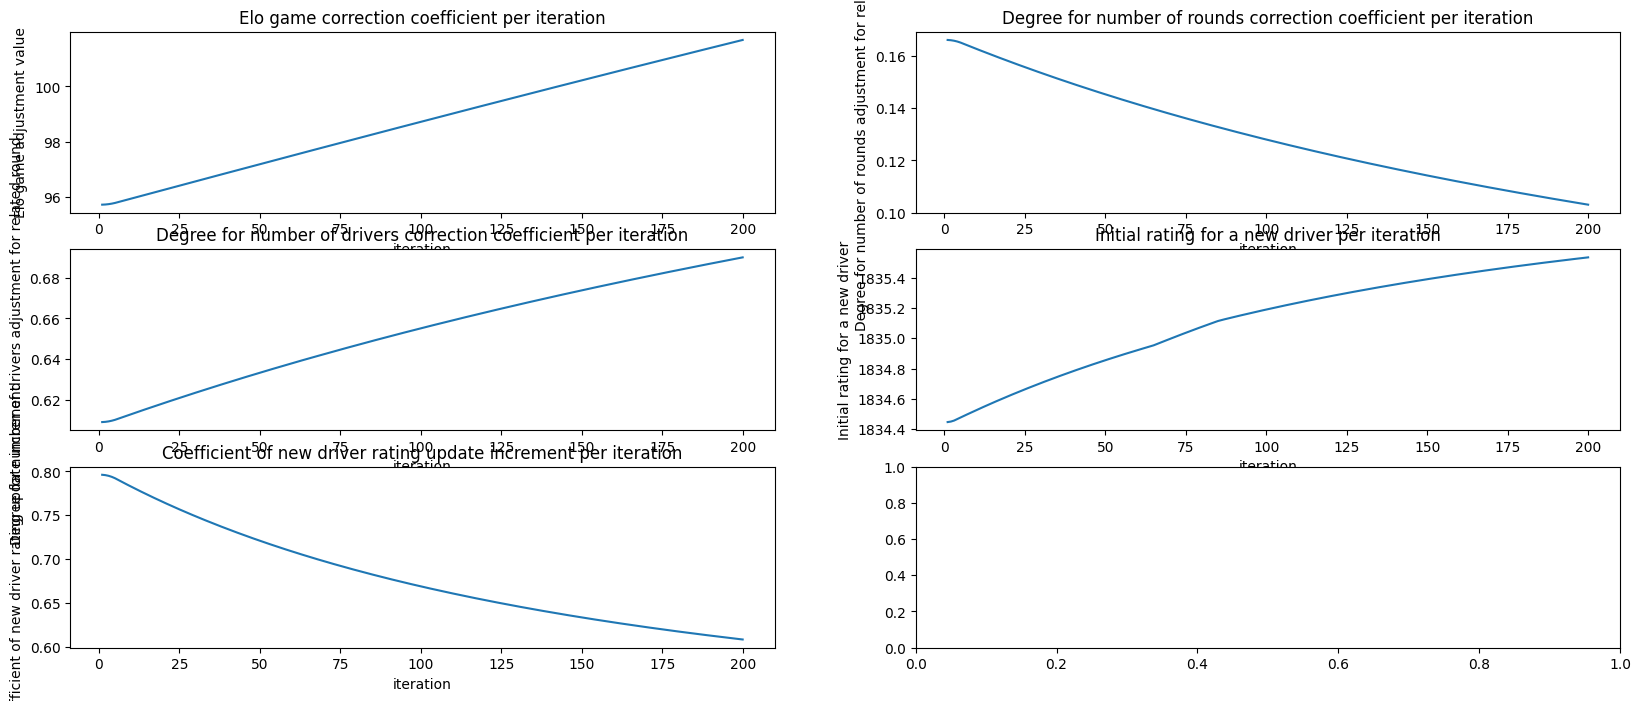

In [222]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 8))
index = 0
axs = axs.flatten()
for col in ['elo_game_value', 'num_rounds_degree', 'num_drivers_degree', 'default_rating', 'new_agent_alpha']:
    axs[index].plot(output_df['iteration'], output_df[col])
    axs[index].set_xlabel('iteration')
    axs[index].set_ylabel(col_name_mapping.get(col))
    axs[index].set_title(titles.get(col))
    index += 1
# plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

In [224]:
titles = {
    0: 'Log loss value per iteration for a validation dataset',
    40: 'Detailed view of log loss value for a validation dataset starting from iteration 40',
}

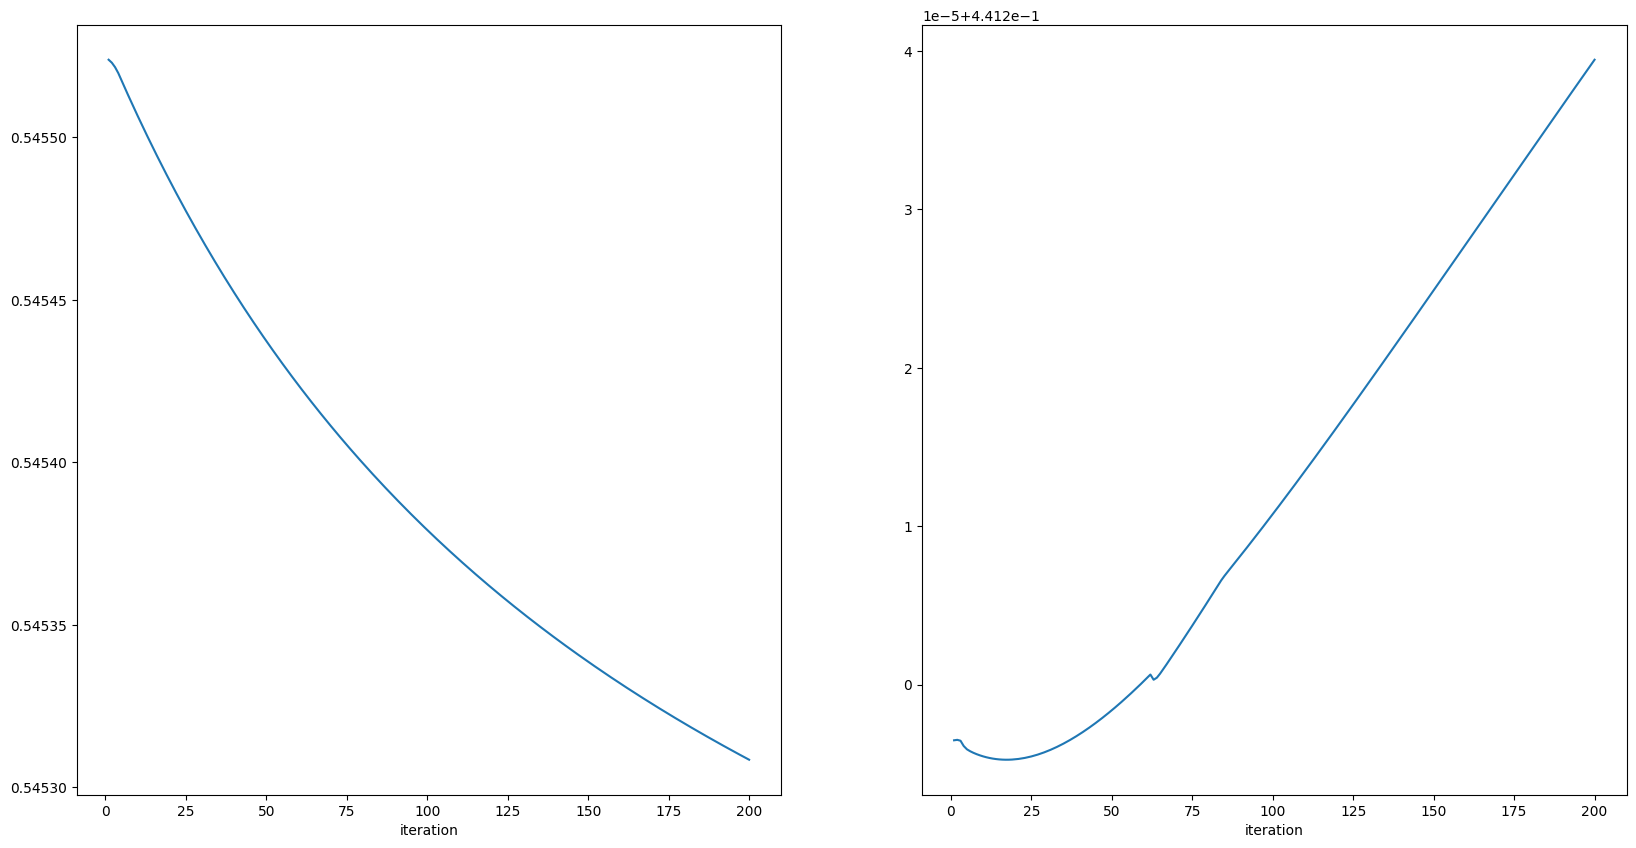

In [226]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for col in ['new_train_log_loss', 'new_validation_log_loss']:
    axs[index].plot(output_df['iteration'], output_df[col])
    axs[index].set_xlabel('iteration')
    axs[index].set_ylabel(col_name_mapping.get(col))
    axs[index].set_title(titles.get(col))
    index += 1
# plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)